In [4]:
import pandas as pd
# ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'  Pandas 1.x와의 하위 호환성을 깨뜨리기 때문에 발생
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

with open('C:/Users/전대혁/TEST_Lab/machine-learning-master/data/pkl/basketball_train.pkl', 'rb') as train_data:
    train = pickle.load(train_data)
    
with open('C:/Users/전대혁/TEST_Lab/machine-learning-master/data/pkl/basketball_train.pkl', 'rb') as test_data:
    test = pickle.load(test_data)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import numpy as np

In [6]:
def svc_param_selection(X, y, nfolds):
    svm_parameters = [
                        {'kernel': ['rbf'],
                         'gamma': [0.00001,0.0001, 0.001, 0.01, 0.1, 1],
                         'C': [0.01, 0.1, 1, 10, 100, 1000]
                        }
                       ]
    
    clf = GridSearchCV(SVC(), svm_parameters, cv=10)
    clf.fit(X_train, y_train.values.ravel())
    print(clf.best_params_)
    
    return clf

In [7]:
X_train = train[['3P', 'BLK']]
y_train = train[['Pos']]
# 최적의 파라미터를 sklearn의 gridsearch를 통해 구함
clf = svc_param_selection(X_train, y_train.values.ravel(), 10)

{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


C:\anaconda3\envs\yolotf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\anaconda3\envs\yolotf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\anaconda3\envs\yolotf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\anaconda3\envs\yolotf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\anaconda3\envs\yolotf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\anaconda3\envs\yolotf\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  w

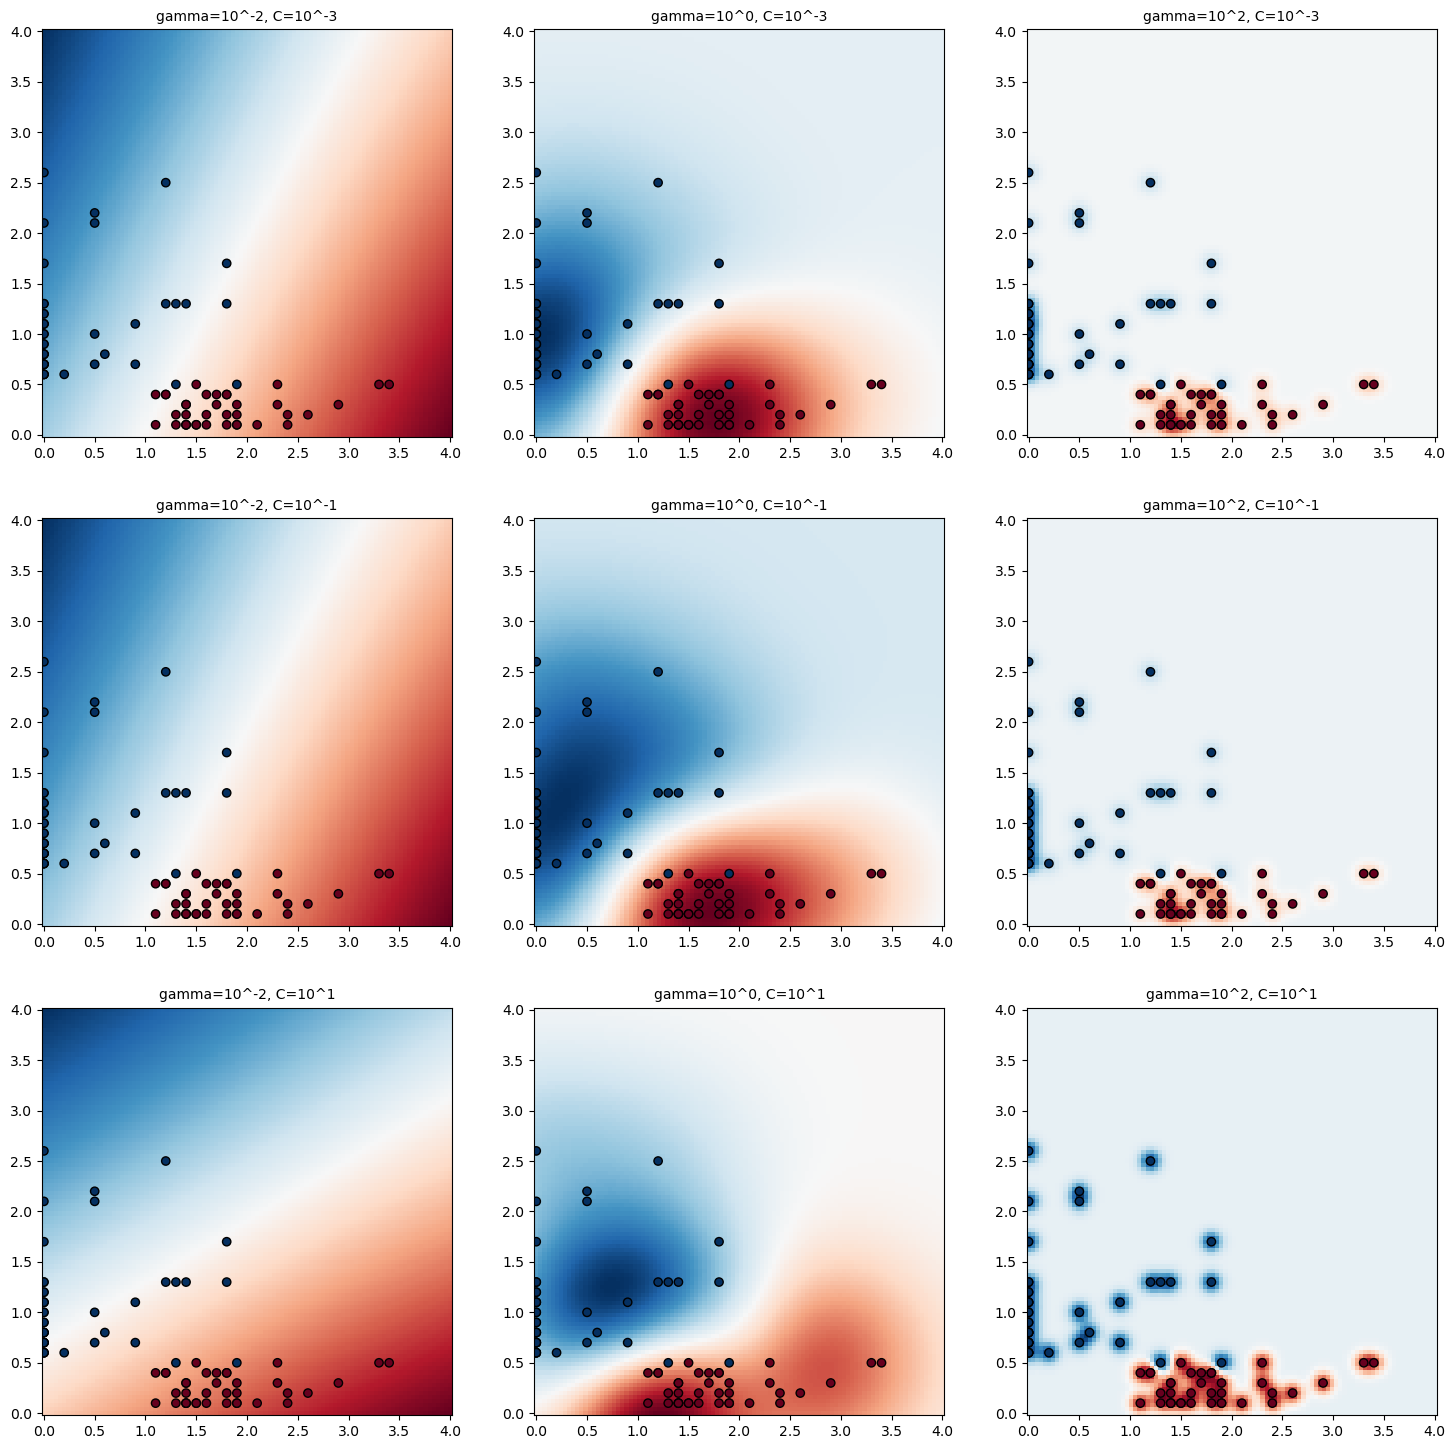

In [8]:
# 시각화를 하기 위해, 최적의 C와 최적의 C를 비교하기 위한 다른 C를 후보로 저장
C_canditates = []
C_canditates.append(clf.best_params_['C'] * 0.01)
C_canditates.append(clf.best_params_['C'])
C_canditates.append(clf.best_params_['C'] * 100)

# 시각화를 하기 위해, 최적의 gamma와 최적의 gamma를 비교하기 위한 다른 gamma를 후보로 저장
gamma_candidates = []
gamma_candidates.append(clf.best_params_['gamma'] * 0.01)
gamma_candidates.append(clf.best_params_['gamma'])
gamma_candidates.append(clf.best_params_['gamma'] * 100)

X = train[['3P', 'BLK']]
Y = train['Pos'].tolist()

# 포지션에 해당하는 문자열 SG와 C를 벡터화
position = []
for gt in Y:
    if gt == 'C':
        position.append(0)
    else:
        position.append(1)

# 각각의 파라미터에 해당하는 SVM 모델을 만들어 classifiers에 저장
classifiers = []
for C in C_canditates:
    for gamma in gamma_candidates:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X, Y)
        classifiers.append((C, gamma, clf))

# 18,18 사이즈의 챠트를 구성
plt.figure(figsize=(18, 18))
xx, yy = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 4, 100))

# 각각의 모델들에 대한 결정 경계 함수를 적용하여 함께 시각화
for (k, (C, gamma, clf)) in enumerate(classifiers):
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 최적의 모델을 포함한 다른 파라미터로 학습된 모델들을 함께 시각화
    plt.subplot(len(C_canditates), len(gamma_candidates), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # 서포트 벡터와 결정경계선을 시각화합니다.
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X['3P'], X['BLK'], c=position, cmap=plt.cm.RdBu_r, 
      edgecolors='k')

In [9]:
# 테스트에 사용될 특징을 지정
X_test = test[['3P', 'BLK']]

# 특징으로 예측할 값 (농구선수 포지션)을 지정
y_test = test[['Pos']]

# 최적의 파라미터로 완성된 SVM에 테스트 데이터를 주입하여, 실제값과 예측값을 얻음
y_true, y_pred = y_test, clf.predict(X_test)

print(classification_report(y_true, y_pred))
print()
print("accuracy : "+ str(accuracy_score(y_true, y_pred)) )

              precision    recall  f1-score   support

           C       1.00      1.00      1.00        43
          SG       1.00      1.00      1.00        37

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80


accuracy : 1.0


In [10]:
# 실제값(ground truth)과 예측값(prediction)이 어느 정도 일치하는 눈으로 직접 비교
comparison = pd.DataFrame({'prediction':y_pred, 'ground_truth':y_true.values.ravel()}) 
comparison

,prediction,ground_truth
0,SG,SG
1,SG,SG
2,C,C
3,SG,SG
4,SG,SG
...,...,...
75,SG,SG
76,SG,SG
77,C,C
78,SG,SG
